# Sargassum Density From AFAI

The goal of this notebook is to convert AFAI data into Saragassum density.

In [1]:
using NetCDF
using Dates
using Statistics

In [2]:
using Makie, CairoMakie
include(joinpath(@__DIR__, "..", "..", "CustomMakie.jl", "src", "geo-methods.jl"))
include(joinpath(@__DIR__, "../../CustomMakie.jl/src/statistic-methods.jl"))

axis (generic function with 1 method)

## Testing

We use the 7-day cumulative AFAI data from [NOAA](https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_atlantic_oceanwatch_AFAI_7D.html). Specifically, we start with April 1 2018 - May 1 2018 and choose a stride of 7 days such that there should be four data snapshots which each correspond to one week of April. The netCDF is downloaded from here [click to download (~150 MB)](https://cwcgom.aoml.noaa.gov/erddap/griddap/noaa_aoml_atlantic_oceanwatch_AFAI_7D.nc?AFAI[(2018-04-08T00:00:00Z):7:(2018-04-29T00:00:00Z)][(0.0):1:(38.0)][(-98.0):1:(-38.0)]).

In [17]:
raw_filename = "afai-7day-fine.nc"
ncinfo(raw_filename)


##### NetCDF File #####

/Users/gagebonner/Desktop/Repositories/SargassumFromAFAI.jl/7day-0.015degree/afai-7day-fine.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
latitude                                            2534                      
time                                                4                         
longitude                                           4001                      

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
AFAI                            FLOAT           longitude latitude time         
latitude                        DOUBLE          latitude                        
time                            DOUBLE          time                            
longitude                   

### Time

The time is measured in `seconds since 1970-01-01T00:00:00Z`.

In [18]:
tref = DateTime(1970, 1, 1, 0, 0, 0)
time = tref + Second.(ncread(raw_filename, "time"))

4-element Vector{DateTime}:
 2018-04-08T12:00:00
 2018-04-15T12:00:00
 2018-04-22T12:00:00
 2018-04-29T12:00:00

### Latitude and Longitude

Latitude is in `degrees N/S` and longitude is in `degrees E/W`.

In [19]:
lat = ncread(raw_filename, "latitude")
lon = ncread(raw_filename, "longitude")

4001-element Vector{Float64}:
 -98.0
 -97.985
 -97.97
 -97.955
 -97.94
 -97.925
 -97.91
 -97.895
 -97.88
 -97.865
   ⋮
 -38.120000000000005
 -38.105000000000004
 -38.09
 -38.075
 -38.06
 -38.045
 -38.03
 -38.015
 -38.0

### AFAI Data

The AFAI is the 7-day cumulative value in reflectance units. It takes values in `(-0.004, 0.006)` and has a fill value of `NaN`. Its dimensions are `(longitude, latitude, time)`.

In [20]:
afai = ncread(raw_filename, "AFAI");
size(afai)

(4001, 2534, 4)

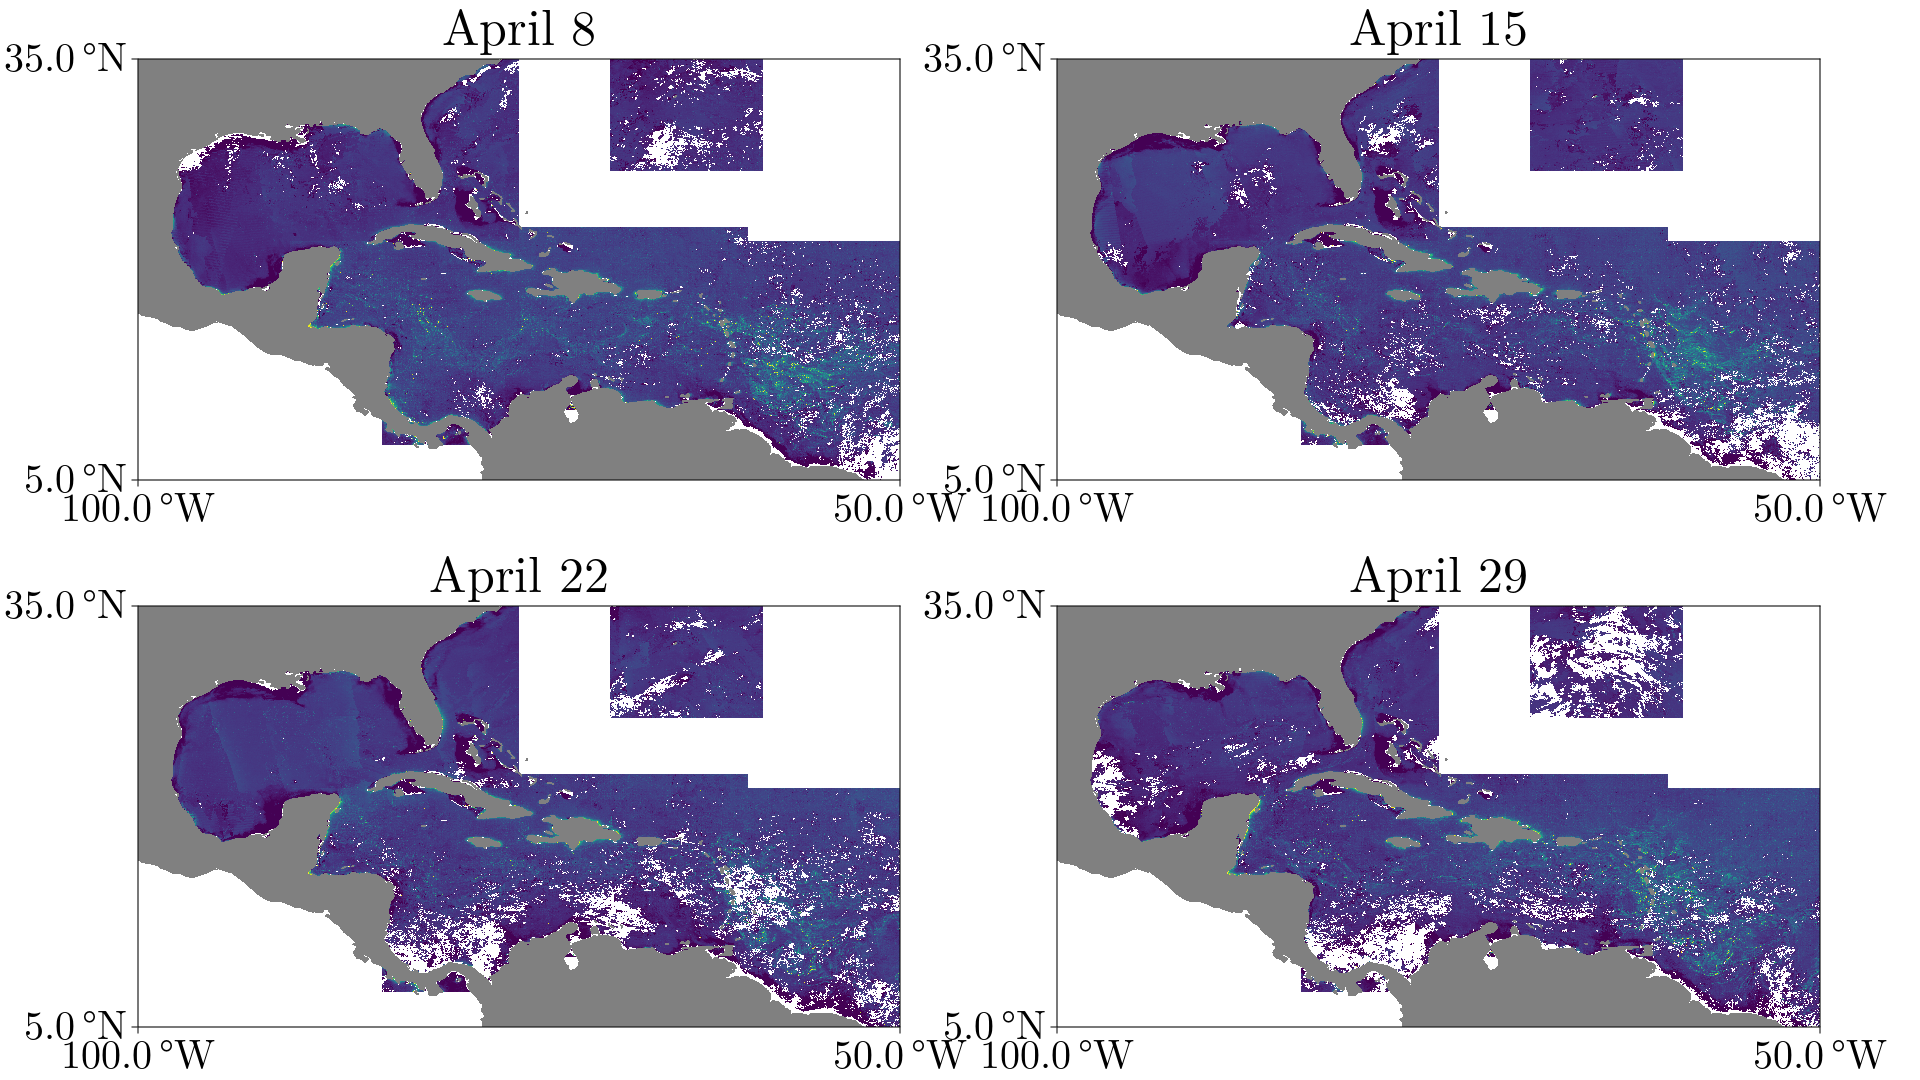

In [23]:
fig = default_fig()

# Day 8
ax = geo_axis(fig[1, 1], title = L"\text{April 8}")
heatmap!(ax, lon, lat, afai[:,:,1])
land!(ax)

# Day 15
ax = geo_axis(fig[1, 2], title = L"\text{April 15}")
heatmap!(ax, lon, lat, afai[:,:,2])
land!(ax)

# Day 22
ax = geo_axis(fig[2, 1], title = L"\text{April 22}")
heatmap!(ax, lon, lat, afai[:,:,3])
land!(ax)

# Day 29
ax = geo_axis(fig[2, 2], title = L"\text{April 29}")
heatmap!(ax, lon, lat, afai[:,:,4])
land!(ax)

fig

### Median Filtering

The following procedure is conducted for each time slice.

We create a new data set `afai_median` such that each point in the lon-lat grid has a value equal to the median `afai` value of the surrounding `51 x 51` point window. `NaN`s are not included in the median calculation, i.e. if a pixel is surrounded by some `NaN`s and some values, the median will be taken over the only the values. If the pixel is surrounded by only `NaN`s, then its value is `NaN`.

In [16]:
afai_median = zeros(Float32, size(afai))
window_size = 50

for t_i = 1:1 # 1:size(afai_median, 3)
    for lon_i = 1:size(afai_median, 1)
        for lat_i = 1:size(afai_median, 2)
            lons = max(1, lon_i - round(Integer, window_size/2)):min(length(lon), lon_i + round(Integer, window_size/2))
            lats = max(1, lat_i - round(Integer, window_size/2)):min(length(lat), lat_i + round(Integer, window_size/2))
            vaid_pixels = [x for x in afai[lons, lats, t_i] if !isnan(x)]

            if length(vaid_pixels) > 0
                afai_median[lon_i, lat_i, t_i] = median(vaid_pixels)
            else
                afai_median[lon_i, lat_i, t_i] = NaN
            end
        end
    end
end

In [11]:
afai |> size

(4001, 2534, 5)

In [14]:
length(lon)

4001

In [23]:
1 + NaN

NaN

In [24]:
10 + NaN

NaN

In [25]:
sum([1, 2, NaN])

NaN

In [26]:
median

UndefVarError: UndefVarError: `median` not defined

In [27]:
using Statistics

In [28]:
Statistics.median

median (generic function with 49 methods)

In [30]:
Statistics.median([1, 2, 3, 4, 5, NaN])

NaN

In [31]:
filter(x -> !isnan(x), [1, 2, 3, NaN])

3-element Vector{Float64}:
 1.0
 2.0
 3.0

In [43]:
round(Integer, 4.3)

4

In [50]:
median([], init = 0.0)

MethodError: MethodError: no method matching median(::Vector{Any}; init::Float64)

Closest candidates are:
  median(::AbstractArray; dims) got unsupported keyword argument "init"
   @ Statistics ~/.julia/juliaup/julia-1.9.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Statistics/src/Statistics.jl:864
  median(::Any) got unsupported keyword argument "init"
   @ Statistics ~/.julia/juliaup/julia-1.9.3+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Statistics/src/Statistics.jl:848
  median(!Matched::Distributions.Frechet) got unsupported keyword argument "init"
   @ Distributions ~/.julia/packages/Distributions/Ufrz2/src/univariate/continuous/frechet.jl:65
  ...


In [60]:
[x for x in afai[300:400,23:2500,1] if !isnan(x)]

72922-element Vector{Float32}:
  0.000247
  0.000247
  0.000247
  0.000604
 -0.00034
 -0.00034
  0.000119
  0.000119
  0.000119
  0.000119
  ⋮
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002
 -0.002

In [53]:
median([1 2 ; 3 NaN])

NaN